# 시간대별 쇼핑 클릭 추이수

In [14]:
import naverAPI as napi
import json
from dotenv import load_dotenv

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import koreanize_matplotlib

from matplotlib.dates import DayLocator

In [15]:
current_dir = os.getcwd()
#print(current_dir)
dotenv_path = os.path.join(current_dir, '.env')
load_dotenv(dotenv_path=dotenv_path)
client_id = os.getenv("NAVER_CLIENT_ID")
client_secret = os.getenv("NAVER_CLIENT_SECRET")

categroy_json = pd.read_json('output/naverCategoryTable.json')
df_category = pd.DataFrame(categroy_json)
df_category[df_category['level']==1]


,id,p_id,name,level
0,50000000,0,패션의류,1
78,50000001,0,패션잡화,1
413,50000002,0,화장품/미용,1
595,50000003,0,디지털/가전,1
1421,50000004,0,가구/인테리어,1
1833,50000005,0,출산/육아,1
2359,50000006,0,식품,1
3046,50000007,0,스포츠/레저,1
3618,50000008,0,생활/건강,1
5054,50000009,0,여가/생활편의,1


In [38]:
def draw_shopping_plot(search_cat, startdate, enddate, title, threshold=30, output = 'output/res_temp.json', gender:str="", ages:list=[]):
 # 음식 카테고리
    if isinstance(search_cat, pd.DataFrame):
        search_cat['param'] = search_cat['id'].astype(str).apply(lambda x: [x])
        test_category_list = search_cat[['name', 'param']].to_dict('records')
        # b = search_cat[['id','name']].to_dict('tight')
        # to_be_found = np.array(b['data'])
        # test_category_list = napi.listToCategoryDict(to_be_found)
        print(len(test_category_list))
        res = napi.createTrendData(client_id, client_secret, test_category_list, startdate, enddate, gender=gender, ages=ages)

        with open(output, 'w', encoding='utf-8') as f:
                    json.dump(res, f, ensure_ascii=False, indent=4)
    
    elif isinstance(search_cat, str):
        with open(search_cat, 'r', encoding='utf-8') as file:
            res = json.load(file)

    
    results = res['datalist']
    all_data = []
    DEFAULT_GROUP = "전체" 

    # 중첩된 구조를 순회하며 'title'과 'group' 정보를 연결
    for item in results:
        current_title = item['title']
        item_data = item['data']
        if item_data:
            is_group_present = 'group' in item_data[0]
        else:
            continue 
        
        for sub_item in item_data:
            if is_group_present:
                current_group = sub_item['group']
            else:
                current_group = DEFAULT_GROUP

            row = {
                'title': current_title,
                'group': current_group, 
                'period': sub_item['period'],
                'ratio': sub_item['ratio']
            }
            all_data.append(row)

    # DataFrame 생성 및 period를 datetime으로 변환
    df = pd.DataFrame(all_data)
    df['period'] = pd.to_datetime(df['period'])

    print("--- 준비된 DataFrame (Title 블록별 Group 처리) ---")
    print(df)
    print("\n--- 'group' 컬럼의 고유 값 ---")
    print(df['group'].unique())

    plt.figure(figsize=(15, 7))
    ax = plt.gca()
    annotation_data = []

    # 2. 'title'과 'group' 컬럼을 조합하여 고유한 그룹핑 기준 생성
    unique_combinations = df.groupby(['title', 'group']).groups.keys()

    # 3. 각 조합별로 반복하며 선 그래프 그리기
    for title_name, group_name in unique_combinations:
        df_combo = df[(df['title'] == title_name) & (df['group'] == group_name)]
        label_name = f"{title_name} - {group_name}"
        
        # plot 함수 실행
        if df_combo['ratio'].max() > threshold:
            line, =plt.plot(
                df_combo['period'], 
                df_combo['ratio'], 
                marker='o',         
                linestyle='-',      
                label=label_name    # 조합별 라벨
        )
            
            if not df_combo.empty:
                last_point = df_combo.iloc[-1]
                annotation_data.append({
                    'x': last_point['period'],
                    'y': last_point['ratio'],
                    'label': label_name,
                    'color': line.get_color() # 플롯에서 할당된 색상을 가져옵니다.
                })

    # 4. 그래프 꾸미기
    plt.title(title)
    plt.xlabel('Period')
    plt.ylabel('Ratio Value')
    plt.ylim((0, 110))
    plt.legend(title='Combination', bbox_to_anchor=(1.05, 1), loc='upper left') 
    plt.grid(True, linestyle='--')
    plt.xticks(rotation=45) 
    ax.xaxis.set_major_locator(DayLocator(interval=1))

    # 모든 x축 레이블 객체를 리스트로 가져옵니다.
    xticklabels = ax.get_xticklabels()

    # 강조하고 싶은 문자열을 정의합니다.
    highlight_name = ["2024-09-14","2024-09-15","2024-09-16","2024-09-17","2024-09-18","2024-09-18", "2025-10-03", "2025-10-04","2025-10-05","2025-10-06","2025-10-07","2025-10-08","2025-10-09", "2025-10-10", "2025-10-11", "2025-10-12"]
    highlight_color = 'red'

    # 레이블 객체를 순회하며 조건 확인
    for label in xticklabels:
        # label.get_text()로 레이블의 문자열 내용을 가져옵니다.
        if label.get_text() in highlight_name:
            label.set_color(highlight_color)
            label.set_fontweight('bold')
            label.set_fontsize(12) # 크기도 변경 가능

    for ann in annotation_data:
        ax.annotate(
            ann['label'],
            xy=(ann['x'], ann['y']),
            xytext=(5, 0), # 라인 끝에서 오른쪽으로 5포인트 이동
            textcoords='offset points',
            color=ann['color'],
            fontsize=10,
            ha='left',
            va='center'
        )
    plt.tight_layout(rect=[0, 0, 0.9, 1])

    plt.show()

    return df


## 사람들이 가장 많이 누른 품목은?
- 추석 전후로 음식이 많을거 같음 $\Rightarrow$ 생활/건강이 많았다
- 의류와 식품이 10/3일에 교차됨
- 전체 클릭수는 추석 연휴보다 전후로 많았다
- 의류 18일 - 19일에 클릭수 급격 증가 $\Rightarrow$ 날씨영향(갑자기 추워질때) -> 아마 겨울의류를 많이 보지 않았을가

--- 준비된 DataFrame (Title 블록별 Group 처리) ---
    title group     period      ratio
0    패션의류    전체 2025-09-26  42.138105
1    패션의류    전체 2025-09-27  45.969084
2    패션의류    전체 2025-09-28  56.465664
3    패션의류    전체 2025-09-29  46.831480
4    패션의류    전체 2025-09-30  45.073904
..    ...   ...        ...        ...
259    도서    전체 2025-10-15  11.276200
260    도서    전체 2025-10-16  10.550310
261    도서    전체 2025-10-17  10.034630
262    도서    전체 2025-10-18   8.738150
263    도서    전체 2025-10-19   9.374190

[264 rows x 4 columns]

--- 'group' 컬럼의 고유 값 ---
['전체']


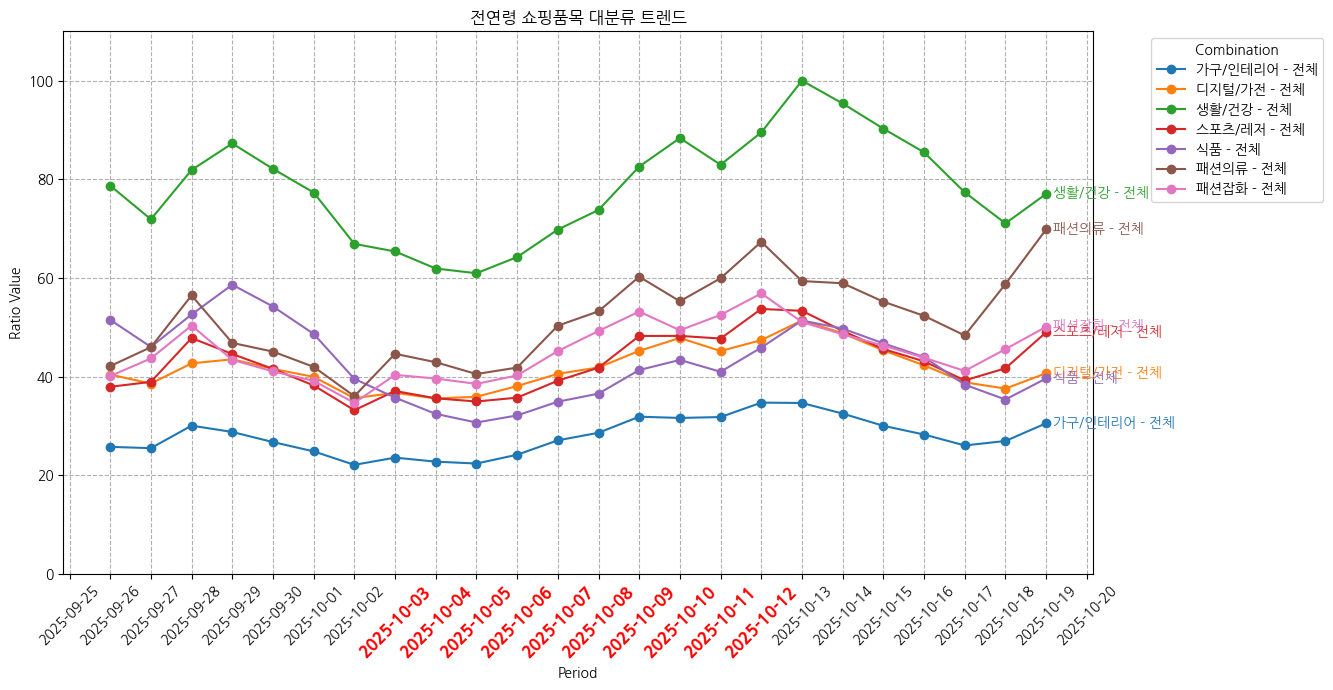

In [39]:

search_cat = df_category[(df_category['level'] == 1) & (df_category['name'] != '면세점')].copy()
#print(search_cat)
#res_ageAll = draw_shopping_plot(search_cat, "2025-09-26", "2025-10-19", output='output/res_ageAll.json')
res_ageAll = draw_shopping_plot('output/res_ageAll.json', "2025-09-26", "2025-10-19", title = '전연령 쇼핑품목 대분류 트렌드')

--- 준비된 DataFrame (Title 블록별 Group 처리) ---
    title group     period      ratio
0    패션의류    전체 2025-09-26  43.481200
1    패션의류    전체 2025-09-27  49.332631
2    패션의류    전체 2025-09-28  57.994709
3    패션의류    전체 2025-09-29  45.329019
4    패션의류    전체 2025-09-30  44.359429
..    ...   ...        ...        ...
259    도서    전체 2025-10-15   6.355460
260    도서    전체 2025-10-16   6.255580
261    도서    전체 2025-10-17   6.007710
262    도서    전체 2025-10-18   5.656900
263    도서    전체 2025-10-19   5.719850

[264 rows x 4 columns]

--- 'group' 컬럼의 고유 값 ---
['전체']


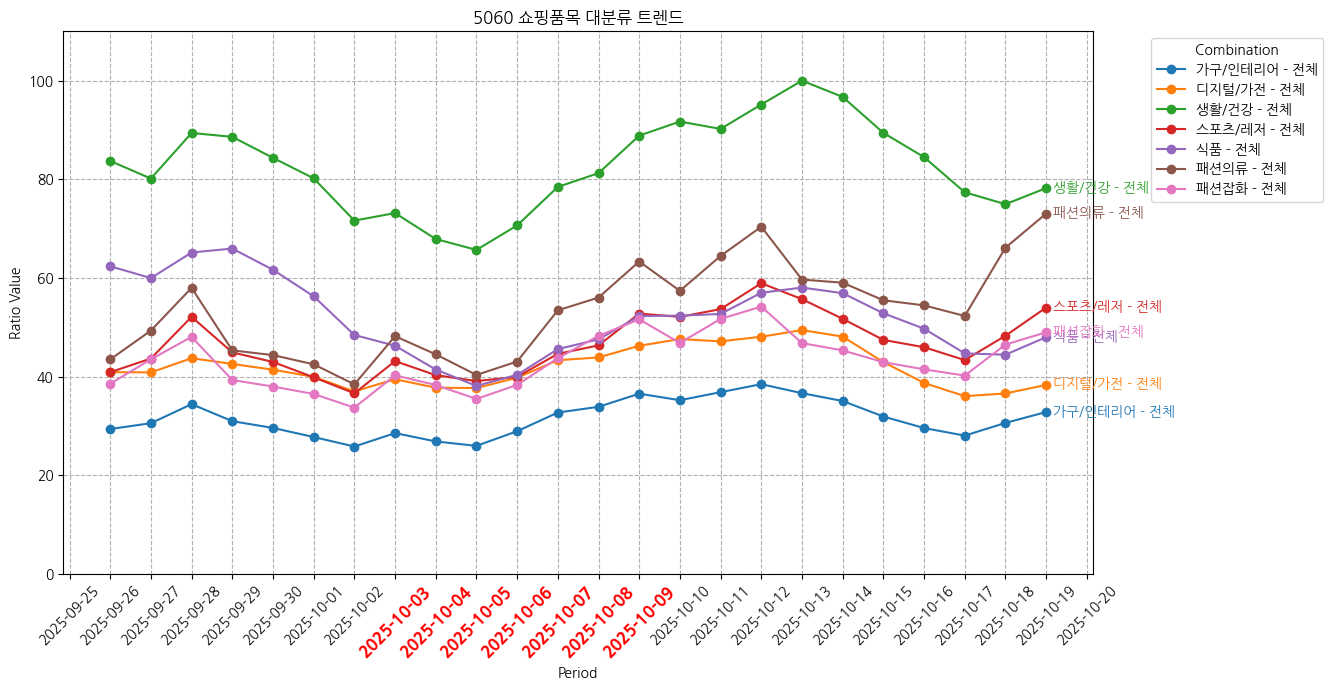

In [36]:
search_cat = df_category[(df_category['level'] == 1) & (df_category['name'] != '면세점')].copy()
#print(search_cat)

output = 'output/res_age2030.json'
#res_age2030 = draw_shopping_plot(search_cat, "2025-09-26", "2025-10-19", '2030 쇼핑품목 대분류 트렌드',output=output, ages=['20', '30'])
#res_age2030 = draw_shopping_plot(output, "2025-09-26", "2025-10-19", '2030 쇼핑품목 대분류 트렌드')

output = 'output/res_age5060.json'
#res_age5060 = draw_shopping_plot(search_cat, "2025-09-26", "2025-10-19", '5060 쇼핑품목 대분류 트렌드',output=output, ages=['50', '60'])
res_age5060 = draw_shopping_plot(output, "2025-09-26", "2025-10-19", '5060 쇼핑품목 대분류 트렌드')


11
--- 준비된 DataFrame (Title 블록별 Group 처리) ---
    title group     period      ratio
0    패션의류    전체 2025-09-26  22.223747
1    패션의류    전체 2025-09-27  24.702217
2    패션의류    전체 2025-09-28  31.597394
3    패션의류    전체 2025-09-29  25.882101
4    패션의류    전체 2025-09-30  24.812463
..    ...   ...        ...        ...
259    도서    전체 2025-10-15   7.304410
260    도서    전체 2025-10-16   6.907470
261    도서    전체 2025-10-17   6.573730
262    도서    전체 2025-10-18   5.989980
263    도서    전체 2025-10-19   6.517690

[264 rows x 4 columns]

--- 'group' 컬럼의 고유 값 ---
['전체']


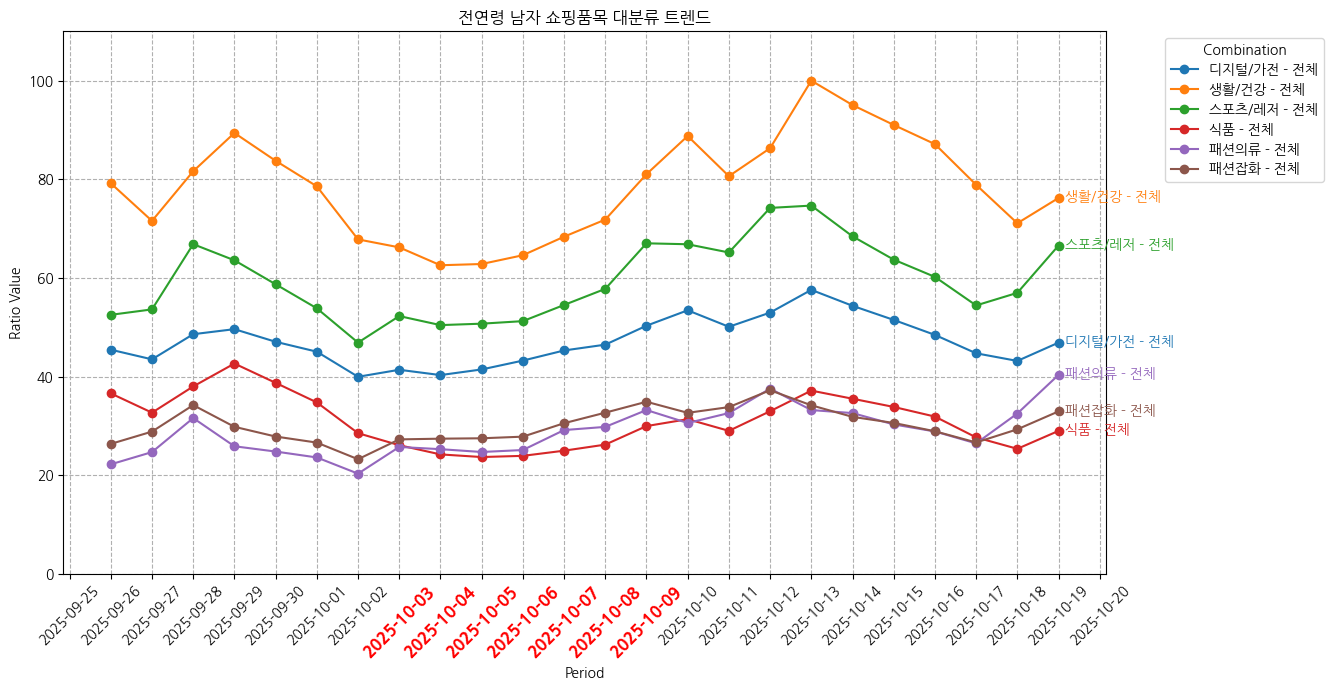

11
--- 준비된 DataFrame (Title 블록별 Group 처리) ---
    title group     period     ratio
0    패션의류    전체 2025-09-26  61.23240
1    패션의류    전체 2025-09-27  67.55751
2    패션의류    전체 2025-09-28  81.81627
3    패션의류    전체 2025-09-29  67.06174
4    패션의류    전체 2025-09-30  64.44617
..    ...   ...        ...       ...
259    도서    전체 2025-10-15  13.84191
260    도서    전체 2025-10-16  12.95238
261    도서    전체 2025-10-17  12.38659
262    도서    전체 2025-10-18  10.68788
263    도서    전체 2025-10-19  11.36057

[264 rows x 4 columns]

--- 'group' 컬럼의 고유 값 ---
['전체']


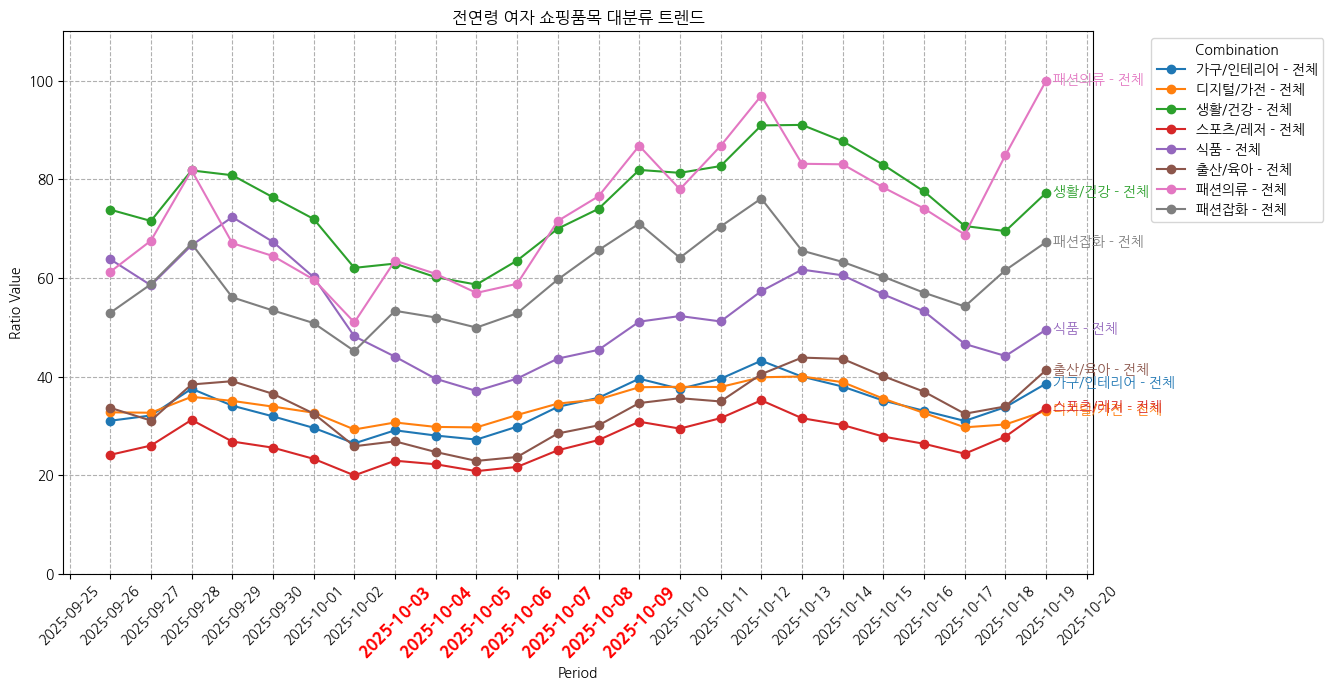

In [37]:
search_cat = df_category[(df_category['level'] == 1) & (df_category['name'] != '면세점')].copy()
#print(search_cat)

output = 'output/res_allAgeM.json'
title = '전연령 남자 쇼핑품목 대분류 트렌드'
res_allAgeM = draw_shopping_plot(search_cat, "2025-09-26", "2025-10-19", title=title,output=output, gender='m')
#res_allAgeM = draw_shopping_plot(output, "2025-09-26", "2025-10-19", title=title)

output = 'output/res_allAgeF.json'
title = '전연령 여자 쇼핑품목 대분류 트렌드'
res_allAgeF= draw_shopping_plot(search_cat, "2025-09-26", "2025-10-19", title=title ,output=output,gender='f')
#res_allAgeF = draw_shopping_plot(output, "2025-09-26", "2025-10-19", title=title)

## 생활/건강이 뭐가 높은거지?
- 추석때 선물로 욕실세트나 아니면 휴지같은것들?, 그러기에는 추석 이후로 더 올라갔는데

**결과**
- 공구가 높다. 이해가 되지 않음 $\Rightarrow$ 공구분류에 많은 카테고리가 있을거 같다. $\Rightarrow$ 생활/건강의 품목이 많아서 그런듯 

In [30]:
search_cat = df_category[df_category['p_id'] == 50000008]
print(len(search_cat))
draw_shopping_plot(search_cat, "2025-09-26", "2025-10-19")

34
34


HTTPError: HTTP Error 429: Too Many Requests

In [31]:

print(df_category[df_category['name']=='주방용품'] )
search_cat = df_category[(df_category['p_id'] == 50000061) | (df_category['p_id'] == 50000165)]
print(len(search_cat))
draw_shopping_plot(search_cat, "2025-09-20", "2025-10-19", 50)

            id      p_id  name  level
4503  50000061  50000008  주방용품      2
35
35


HTTPError: HTTP Error 429: Too Many Requests

## 다음은 의류에 대해서 보자
**결과**
- 아까 봤듯이 날씨 때문에 10/18, 10/19에 클릭수 급증
- 남성의류와 여성의류 검색 추이 비슷
    - 궁금한점 : 남자, 여자는 무슨 의류를 더많이 검색했을까



In [32]:

print(df_category[df_category['name']=='패션의류'] )
search_cat = df_category[(df_category['p_id'] == 50000000)]
print(len(search_cat))
print(search_cat['name'])
draw_shopping_plot(search_cat, "2025-09-20", "2025-10-19", threshold=0, gender="f")

         id  p_id  name  level
0  50000000     0  패션의류      1
4
1          여성의류
23    여성언더웨어/잠옷
48         남성의류
66    남성언더웨어/잠옷
Name: name, dtype: object
4


HTTPError: HTTP Error 429: Too Many Requests

         id  p_id  name  level
0  50000000     0  패션의류      1
4
1          여성의류
23    여성언더웨어/잠옷
48         남성의류
66    남성언더웨어/잠옷
Name: name, dtype: object
4


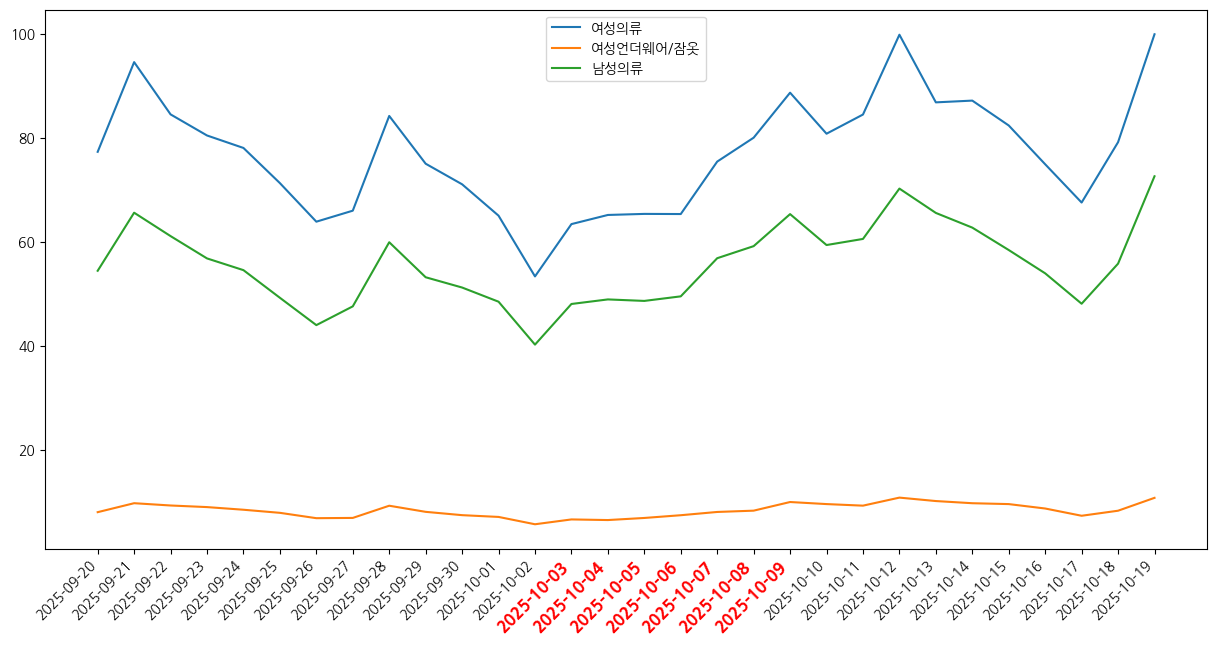

In [16]:

print(df_category[df_category['name']=='패션의류'] )
search_cat = df_category[(df_category['p_id'] == 50000000)]
print(len(search_cat))
print(search_cat['name'])

draw_shopping_plot(search_cat, "2025-09-20", "2025-10-19", threshold=10, ages=['10', '20', '30'])